In [1]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

In [3]:
# Load and view the data
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(10695, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


In [4]:
train['growth_stage'].unique()

array([4, 1, 6, 3, 7, 2, 5])

<Figure size 432x288 with 0 Axes>

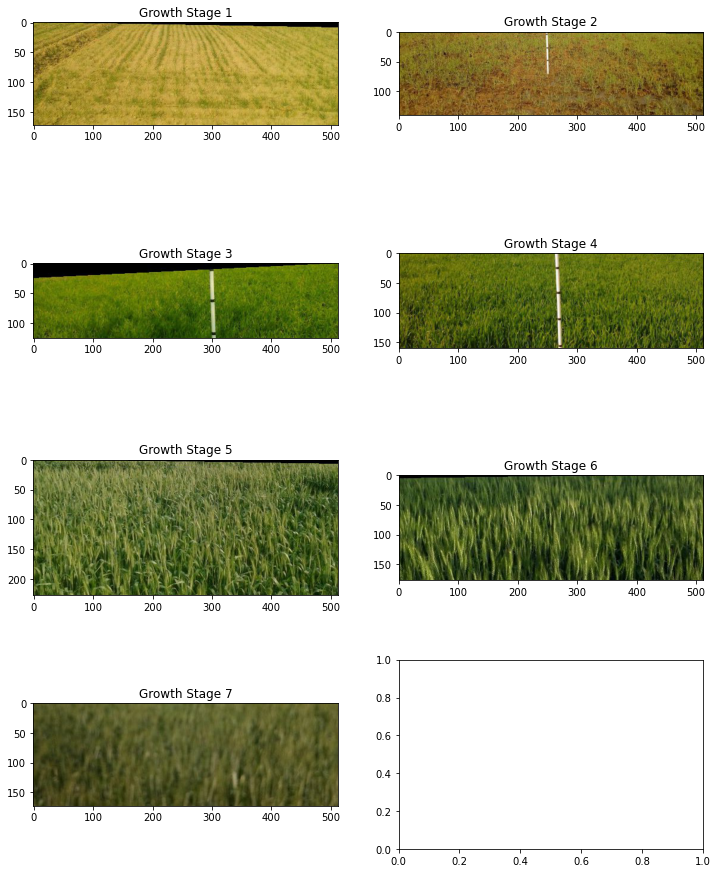

In [5]:
# Plotting an example of each growth stage:
plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

for i, ax in enumerate(axs.flatten()):
  if i+1 in train['growth_stage'].unique(): # If i+1 is a valid growth stage
    im_id = train.loc[(train.growth_stage == i+1)].sample()['UID'].values[0] # Get the ID of an image with the growth stage i+1
    im = PImage.open(f'Images/{im_id}.jpeg')
    ax.imshow(im)
    ax.set_title( f'Growth Stage {i+1}')

In [6]:
# HOW MANY IMS FROM EACH GROWTH PHASE DO WE HAVE?
train.growth_stage.value_counts()

1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64

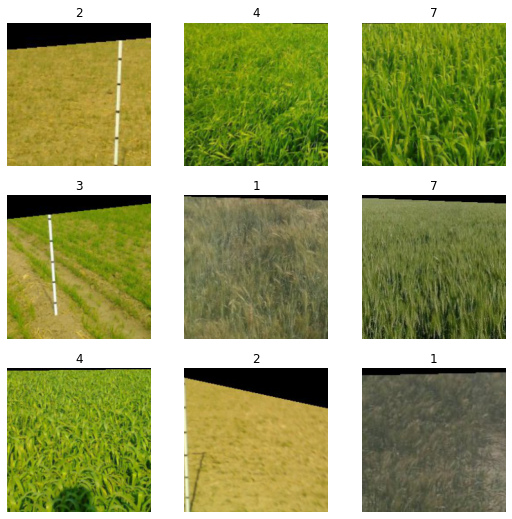

In [7]:
dls = ImageDataLoaders.from_df(train, path='./Images/', suff='.jpeg', label_col='growth_stage', item_tfms=Resize(224))
dls.show_batch()

In [8]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3) # the 3 here tells it to train the head then fine-tune the whole network for 3 epochs

epoch,train_loss,valid_loss,error_rate,time
0,2.114248,1.571958,0.544179,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.523624,1.318179,0.494624,00:50
1,1.338515,1.180133,0.447873,00:49
2,1.191943,1.154073,0.434315,00:49


In [9]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [10]:
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.get_preds(dl=tdl) # Get model predictions
preds[0].shape # 5 sets of probabilities - one for each class. The high quality labels must not cover a few of the growth phases

torch.Size([3558, 7])

In [11]:
learn.dls.vocab # The classes associated with the probabilities output

(#7) [1,2,3,4,5,6,7]

In [12]:
# Converting the predicted probabilities into classes:
class_indexes = np.argmax(preds[0], axis=1)
classes = [learn.dls.vocab[idx] for idx in class_indexes]
classes[:3] # We've found the class with the highest probability - these are our predictions

[5, 4, 1]

In [13]:
# Update the submission dataframe with our predictions
ss['growth_stage'] = classes
ss.head()

,UID,growth_stage
0,F3LbWkZq,5
1,6P4wLVzI,4
2,Tn6HIrdS,1
3,EYM5R1TK,4
4,fkcevlA0,5


In [14]:
ss = pd.read_csv('SampleSubmission.csv')
ss['growth_stage'] = (preds[0] * tensor([int(c) for c in learn.dls.vocab])).sum(dim=1)
ss.head() # Now we have outputs that aren't restricted to the integer growth phase numbers

,UID,growth_stage
0,F3LbWkZq,4.622461
1,6P4wLVzI,3.999245
2,Tn6HIrdS,2.604132
3,EYM5R1TK,4.095449
4,fkcevlA0,5.392435


In [15]:
ss.to_csv('sub2.csv', index=False)

In [16]:
#Regression

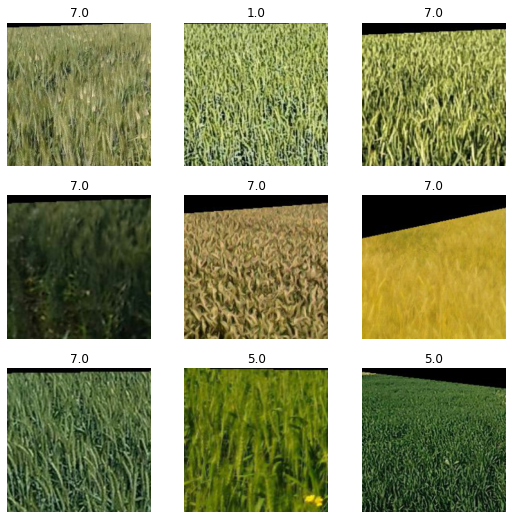

In [18]:
dls = ImageDataLoaders.from_df(train, # train_hq if you only want the smaller high-quality set of images
                               path='Images/', suff='.jpeg', label_col='growth_stage', item_tfms=Resize(224), 
                               y_block=RegressionBlock) # The only other change!
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=rmse) # A new metric
learn.fine_tune(15) # Train a little longer

In [ ]:
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [ ]:
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier
ss.to_csv('sub3.csv', index=False)

In [ ]:
sub2 = pd.read_csv('sub2.csv')
sub3 = pd.read_csv('sub3.csv')
merged = pd.merge(sub2, sub3, on='UID') # Will give two columns of preds - growth_stage_x and growth_stage_y
merged['growth_stage'] = (merged['growth_stage_x'] + merged['growth_stage_y'])/2
merged[['UID', 'growth_stage']].to_csv('sub_ensemble.csv', index=False)